# Projekt - otoczka wypukła

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import functools
import time

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

## Dane 


In [3]:
import random
import math

def generate_random(qnt=100,m=-100,M=100):
    data = []
    for i in range(qnt):
        x = random.uniform(m,M)
        y = random.uniform(m,M)
        data.append((x,y))
    return data
        

def generate_circle(qnt,r,center):
    data= []
    for i in range(qnt):
        rd = math.pi * 2 * random.random()
        x = math.sin(rd) * r +center[0]
        y = math.cos(rd) * r + center[1]
        data.append((x,y))
    return data

def generate_rectangle(qnt=10,LL=(-10,-10),UR=(10,10)):
    data= []
    a  = (UR[0]-LL[0])
    b= (UR[1]-LL[1])
    l = 2*a + 2*b
    for i in range(qnt):
        p = random.uniform(0,l)
        if p <= a:
            x = p + LL[0]
            y = LL[1] 
        elif p <= 2*a:
            x= p -a +LL[0]
            y= UR[1] 
        elif p <= 2*a +b:
            x= LL[0] 
            y= p -2*a  + LL[1]
        else: 
            x = UR[0] 
            y= p-2*a-b +LL[1]
        data.append((x,y))
    return data
    
    
def generate_square(axis =20,diagonal=25,LL=(0,0),UR=(10,10)):
    data= []
    data.append(LL)
    data.append(UR)
    data.append((LL[0],UR[1]))
    data.append((UR[0],LL[1]))
    
    a  = (UR[0])

    
    for i in range(axis):
        p = random.uniform(0,a)
        x=p
        y=0
        data.append((x,y))
        
    for i in range(axis):
        p = random.uniform(0,a)
        x=0
        y=p
        data.append((x,y))  
    
    for i in range(diagonal):
        x = random.uniform(0,UR[0])
        data.append((x,x))
    for i in range(diagonal):
        x = random.uniform(LL[0],UR[0])
        data.append((x,-x + UR[1]))
    
    return data  




## Prezentacja danych

<IPython.core.display.Javascript object>


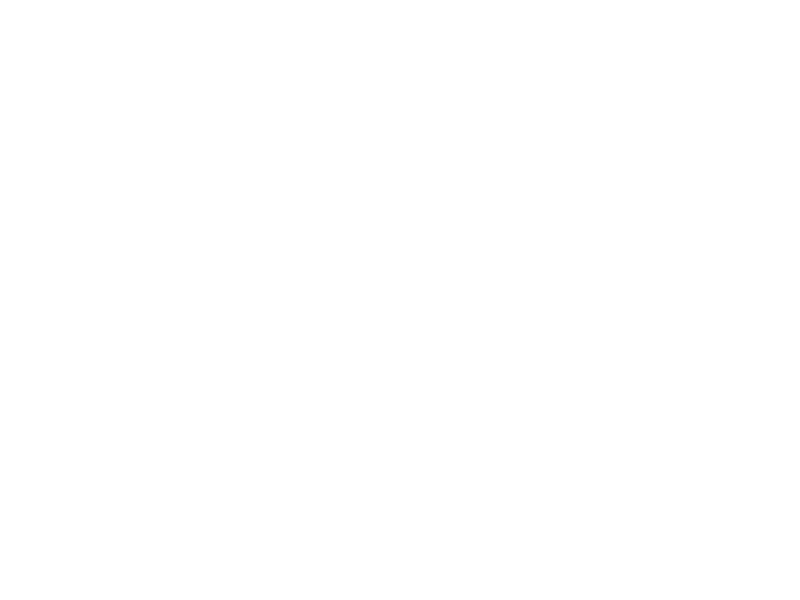

In [4]:
%matplotlib notebook
data1 = generate_random(qnt=100,m=-100,M=100)
data2 = generate_circle(100,100,(0,0))
data3 = generate_rectangle(qnt=100,LL=(-10,-10),UR=(10,10))
data4 = generate_square(axis =25,diagonal=20,LL=(0,0),UR=(10,10))
scenes=[Scene( [ PointsCollection(data1, color='green', marker = ".")]),  
        Scene([ PointsCollection(data2, color='red', marker=".")]),
        Scene([PointsCollection(data3, color='blue')]),
        Scene([PointsCollection(data4, color='orange',marker =".")]),]
             

plot=Plot(scenes = scenes)
plot.draw() 

In [5]:
def det3x3(a,b,c):
    eps=1e-8
    d= ((a[0]*b[1] + a[1]*c[0]+ b[0]*c[1] - b[1]*c[0] - a[1]*b[0]-a[0]*c[1]))
    if d > eps: return 1
    elif d < -eps: return -1
    else: return 0

def distance(a,b):
    return math.sqrt((b[0] - a[0])**2 + (b[1]-a[1])**2)

def orient(a,b,c):
    x= det3x3(a,b,c)
    return -x


## Algorytm Grahama

In [6]:
def graham(data):
    
    scenes=[]
    scenes.append(Scene( [ PointsCollection(data, color='green')]))
    data.sort(key =lambda item: (item[1],item[0]))
    p0 =data[0]
    data= data[1:]
    data = sorted(data, key=functools.cmp_to_key(lambda x,y: orient(p0,x,y)))
    m = len(data)
    data_d=[]
    data_d.append(p0)
    data_d.append(data[0])
    
    for i in range (1,m):
        p=data_d.pop()
        d=det3x3(p0,p,data[i])
        if d ==0:
            if distance(p0,p) > distance(p0,data[i]):
                data_d.append(p)
            else: data_d.append(data[i])
        else: 
            data_d.append(p)
            data_d.append(data[i])

    scenes.append(Scene( [ PointsCollection(data_d, color='green')]))
    scenes.append(Scene( [ PointsCollection(data_d, color='green'),
                         PointsCollection([p0],color='red')]))
    
    lines=[]
    s=[]
    s.append(p0)
    s.append(data_d[1])
    i=2
    lines.append([s[0],s[1]])
    scenes.append(Scene( [ PointsCollection(data_d, color='green')],
                       [LinesCollection(lines[:],color='black')]))
    

    while i < len(data_d): 
        pt=s.pop()
        pp=s.pop()
        pi=data_d[i]
        
        if orient(pp,pt,pi) < 0:
            s.append(pp)
            s.append(pt)
            s.append(pi)
            lines.append([pt,pi])
            scenes.append(Scene( [ PointsCollection(data_d, color='green'),
                                 PointsCollection(s[:], color='blue'),
                           PointsCollection([pt,pp,pi], color='red')],
                       [LinesCollection(lines[:],color='black')]))
            i+=1
        elif orient(pp,pt,pi) ==0:
            s.append(pp)
            s.append(pi)
            lines.pop()
            lines.append([pp,pi])
            scenes.append(Scene( [ PointsCollection(data_d, color='green'),
                                  PointsCollection(s[:], color='blue'),
                           PointsCollection([pt,pp,pi], color='red')],
                       [LinesCollection(lines[:],color='black')]))
            i+=1
        else:
            s.append(pp)
            lines.pop()
            scenes.append(Scene( [ PointsCollection(data_d, color='green'),
                                  PointsCollection(s[:], color='blue'),
                           PointsCollection([pt,pp,pi], color='red')],
                       [LinesCollection(lines[:],color='black')]))
    
    
    lines.append([s[-1],p0])
        
    scenes.append(Scene([ PointsCollection(data_d, color='green' ),
                           PointsCollection(s[:], color='blue')],
                       [LinesCollection(lines[:],color='black')]))
    return scenes,s

4


<IPython.core.display.Javascript object>


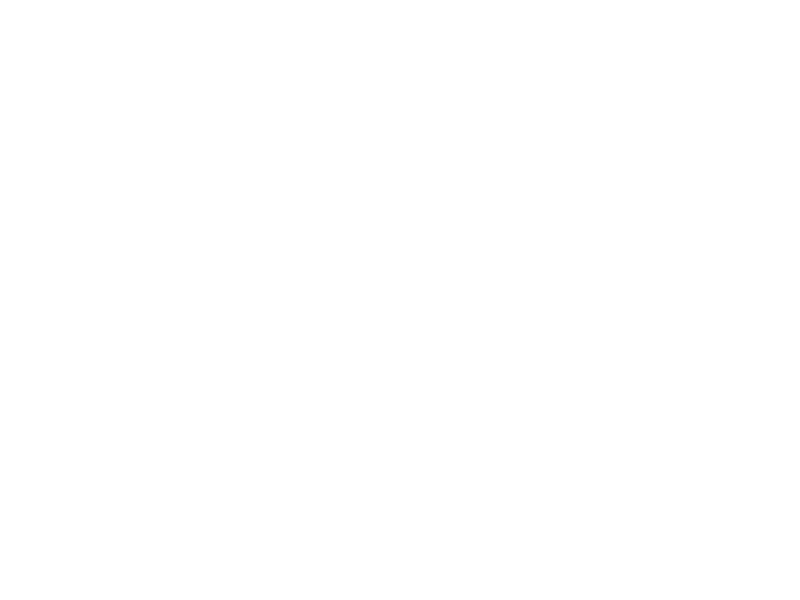

[(0, 0), (10, 0), (10, 10), (0, 10)]


In [7]:
s,x=graham(data4)
print(len(x))
plot1=Plot(scenes = s)
plot1.draw()
print(x)


## Jarvis

In [8]:
def min_angle(a,b,c):
    if a==b: return c
    if b==c: return b
    d = det3x3(a,b,c)
    if d ==0:  
        if distance(a,b) > distance(a,c): return b
        else: return c
    elif d > 0: return b
    else: return c

In [9]:
def min_angleJarvis(a,b,c):
    if a==b: return c,None
    if b==c: return b,None
    d = det3x3(a,b,c)
    if d ==0:  
        if distance(a,b) > distance(a,c):
            return b,c
        else:
            return c,b
            
    elif d > 0: return b,None
    else: return c,None

In [10]:
import time
def jarvis(data):
    d=set(data)
    
    eps=1e-7
    p0=min(d,key=lambda x: (x[1],x[0]))
    scenes=[]
    l=[]
    scenes.append(Scene( [ PointsCollection(data, color='green')]))
    s=[p0]
    p=p0
    while True:
        pi=p
        tmp=[]
        for pkt in d:
            if pkt!=p:
                pi,x=min_angleJarvis(p,pi,pkt)   
                if x!= None:
                    tmp.append(x)
                    
        for pkt in tmp:
            d.remove(pkt)
                
        if len(s)>=1:
            l.append([s[len(s)-1],pi])
        scenes.append(Scene([ PointsCollection(data, color='green' ),
                         PointsCollection([p,pi], color='red'),
                           PointsCollection(s[:], color='blue')],
                           [LinesCollection(l[:],color='black')]))
        
        p=pi
        if p==p0: break
        s.append(pi)
        
    return scenes,s
    

4


<IPython.core.display.Javascript object>


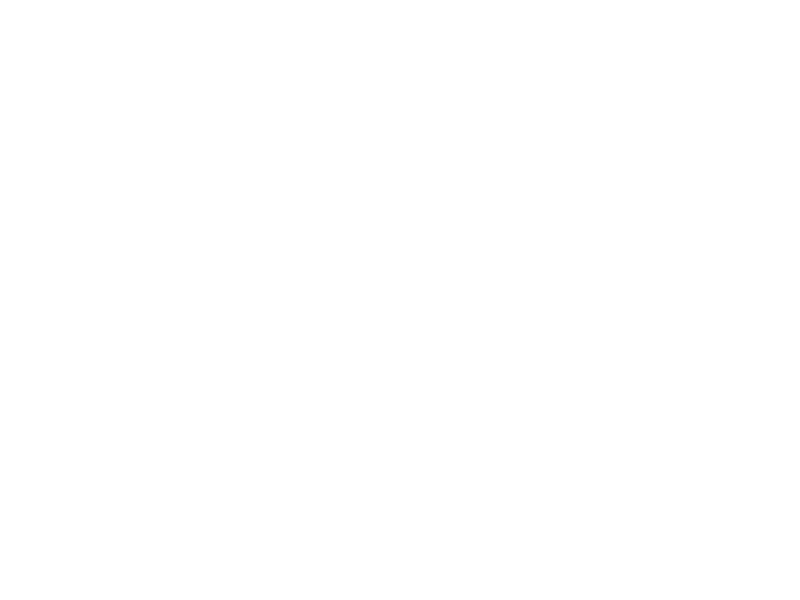

[(0, 0), (10, 0), (10, 10), (0, 10)]


In [11]:
s,x=jarvis(data4)
plot2=Plot(scenes = s)
print(len(x))
plot2.draw()
print(x)


##  Dolna i górna

In [12]:
def lowerAndUpperWithScenes(data):
    data = sorted(data, key=lambda x: x[1])
    data = sorted(data, key=lambda x: x[0])
    scene=[]
    lines1=[]
    scene.append(Scene([PointsCollection(data)]))
    stackL=[]
    stackL.append(data[0])
    stackL.append(data[1])
    lines1.append([data[0],data[1]])
    for i in range(2,len(data)):
        p=data[i]
        scene.append(Scene([PointsCollection(data),
                          PointsCollection([p],color='red')],
                          [LinesCollection(lines1[:],color='green')]))
        
        if orient(stackL[-2],stackL[-1],p)!=-1: 
            stackL.pop()
            lines1.pop()
            scene.append(Scene([PointsCollection(data),
                          PointsCollection([p],color='red')],
                          [LinesCollection(lines1[:],color='green')]))
            while len(stackL)>1 and orient(stackL[-2],stackL[-1],p)!=-1:
                stackL.pop()
                lines1.pop()
                scene.append(Scene([PointsCollection(data),
                          PointsCollection([p],color='red')],
                          [LinesCollection(lines1[:],color='green')]))
                
                
        lines1.append([stackL[-1],p])
        stackL.append(p)
        scene.append(Scene([PointsCollection(data),
                          PointsCollection([p],color='red')],
                          [LinesCollection(lines1[:],color='green')]))
        
    stackU=[]
    lines2=[]
    stackU.append(data[0])
    stackU.append(data[1])
    lines2.append([data[0],data[1]])
    for i in range(2,len(data)):
        p=data[i]
        scene.append(Scene([PointsCollection(data),
                          PointsCollection([p],color='red')],
                          [LinesCollection(lines2[:],color='black'),
                          LinesCollection(lines1[:],color='green')]))
        if orient(stackU[-2],stackU[-1],p)!=1: 
            stackU.pop()
            lines2.pop()
            scene.append(Scene([PointsCollection(data),
                          PointsCollection([p],color='red')],
                          [LinesCollection(lines2[:],color='black'),
                        LinesCollection(lines1[:],color='green')]))
            while len(stackU)>1 and orient(stackU[-2],stackU[-1],p)!=1:
                stackU.pop()
                lines2.pop()
                scene.append(Scene([PointsCollection(data),
                          PointsCollection([p],color='red')],
                          [LinesCollection(lines2[:],color='black'),
                          LinesCollection(lines1[:],color='green')]))
                
        lines2.append([stackU[-1],p])     
        stackU.append(p)
        scene.append(Scene([PointsCollection(data),
                          PointsCollection([p],color='red')],
                          [LinesCollection(lines2[:],color='black'),
                          LinesCollection(lines1[:],color='green')]))
        
    scene.append(Scene([PointsCollection(data)],
                    [LinesCollection(lines2[:],color='black'),
                    LinesCollection(lines1[:],color='green')]))
    
    result=[]
    result=stackL[:]
    for i in range (1,len(stackU)-1):
        result.append(stackU[i])

    return scene,result
    
    
        
        
    

11


<IPython.core.display.Javascript object>


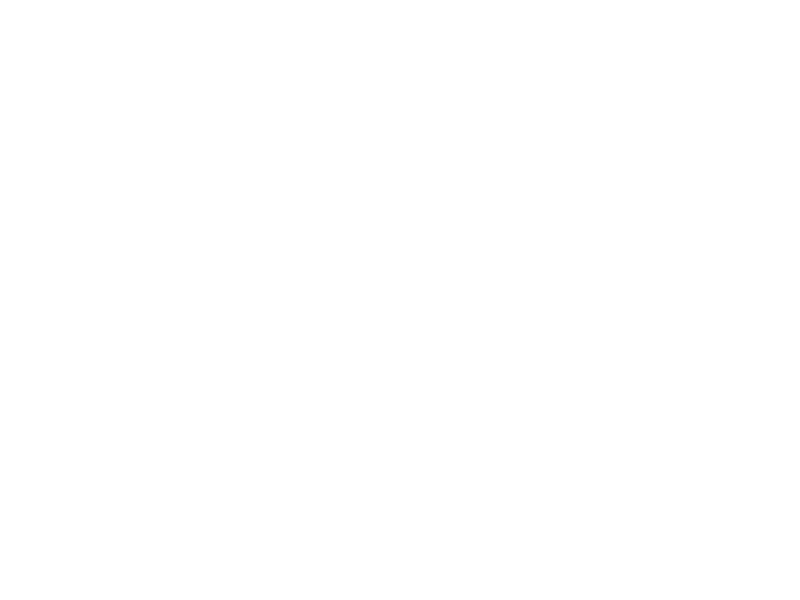

In [13]:
s,r=lowerAndUpperWithScenes(data1)
print(len(r))
plot3=Plot(scenes = s)
plot3.draw()

## QuickHull

In [14]:
def findDistance(p1,p2,p3):
    return abs((p2[0]-p1[0])*(p1[1]-p3[1])-(p1[0]-p3[0])*(p2[1]-p1[1]))


def StartQuickHull(data):
    scenesQuickHull.append(Scene([PointsCollection(data)]))
    data.sort(key=lambda x: x[1])
    data.sort(key=lambda x: x[0])
    Left=data[0]
    Right=data[-1]
    upper=[]
    lower=[]
    for p in data:
        if orient(Left,Right,p)==1:
            lower.append(p)
        elif orient(Left,Right,p)==-1:
            upper.append(p)
    
    QuickHull(Left,Right,upper,data) 
    QuickHull(Right,Left,lower,data)

In [15]:
def QuickHull(a,b,S,data):

    if len(S)==0: 
        linesQH.append([a,b])
        result.add(a)
        result.add(b)
        scenesQuickHull.append(Scene([PointsCollection(data)],
                                    [LinesCollection(linesQH[:],color='black')]))
        return
    elif len(S)==1:
        linesQH.append([a,S[0]])
        linesQH.append([S[0],b])
        result.add(S[0])
        result.add(a)
        result.add(b)
        scenesQuickHull.append(Scene([PointsCollection(data)],
                                    [LinesCollection(linesQH[:],color='black'),
                                    LinesCollection([[a,b]],color='red')]))
        
        return
    else:
        maxD=0
        p=S[0]
        for el in S:
            if findDistance(a,b,el) >maxD:
                p=el
                maxD=findDistance(a,b,el)
        array1=[]
        array2=[]
        for el in S:
            if orient(a,p,el)==-1:
                array1.append(el)
            elif orient(p,b,el)==-1:
                array2.append(el)
                
        scenesQuickHull.append(Scene([PointsCollection(data)],
                                    [LinesCollection(linesQH[:],color='black'),
                                    LinesCollection([[a,b],[a,p],[b,p]],color='red')]))
                
        
    
        QuickHull(a,p,array1,data)
        QuickHull(p,b,array2,data)
                
    
        
    

11


<IPython.core.display.Javascript object>


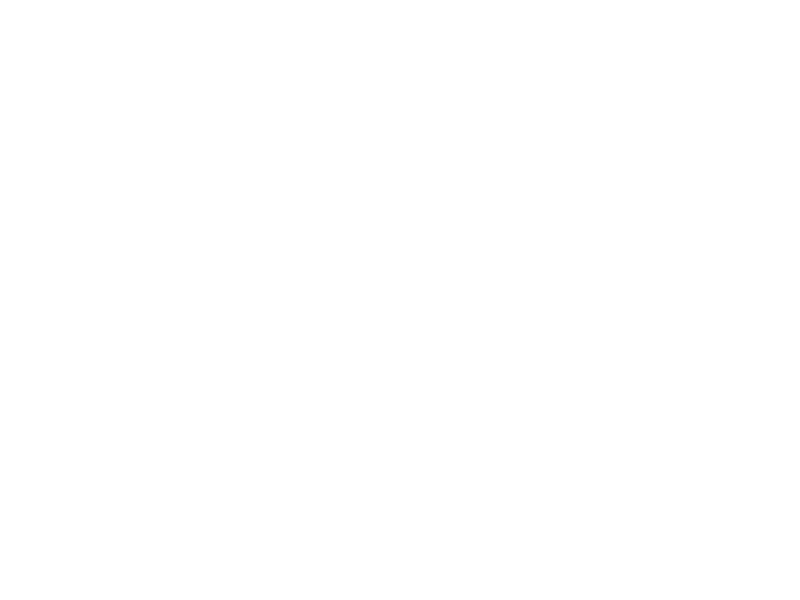

In [16]:
linesQH=[]
scenesQuickHull=[]
result=set()
StartQuickHull(data1)
print(len(result))
#print(result)
plot4=Plot(scenes = scenesQuickHull)
plot4.draw()

## algorytm Chan'a

In [17]:
def PartialHullWithScenes(data,m,scenes):
    scenes.append(Scene([PointsCollection(data)]))
    n=len(data)
    convexHull=[]
    r=math.ceil(len(data)/m)
    p1=data[0]
    S=[[] for i in range (r)]
    for i in range (n):
        S[i%r].append(data[i])
        if p1[1]> data[i][1]:
            p1=data[i]
        elif p1[1]== data[i][1]:
            if p1[0]> data[i][0]:
                p1=data[i]
        
    convexHull.append(p1)
    
    result=[[] for i in range(r)]
    for i in range (len(S)):
        result[i]=grahamChan(S[i])
    
    
    lines=[]
    for s in result:
        for i in range(0,len(s)):
            lines.append([s[i],s[(i+1)%len(s)]])
            
    scenes.append(Scene([PointsCollection(data)],[LinesCollection(lines[:],color='green')]))
                       
            
    currentLine=[]
    p0=p1
    for i in range (m):
        currentLine.append([p0,p0])
        q=[]
        for s in result: 
            pi=p1
            for pkt in s:
                if pkt!=p1:
                    pi=min_angle(p1,pi,pkt) 
            q.append(pi)
        
        p=p1
        for pkt in q:
            if pkt!=p1:
                scenes.append(Scene([PointsCollection(data),
                                    PointsCollection(convexHull[:],color='red')],
                                  [LinesCollection(lines[:],color='green'),
                                  LinesCollection([[p1,pkt]],color='blue'),
                                  LinesCollection(currentLine[:],color='red')]))
                p=min_angle(p1,p,pkt) 
        
        if p==p0:
            currentLine.append([convexHull[-1],p])
            scenes.append(Scene([PointsCollection(data),
                                PointsCollection(convexHull[:],color='red')],
                                  [LinesCollection(lines[:],color='green'),
                                  LinesCollection(currentLine[:],color='red')]))
            return convexHull
            
        else:
            convexHull.append(p)
            currentLine.append([convexHull[-2],convexHull[-1]])
            p1=p
            
            
        
    return None
    
    
    

In [18]:
def Chan(data,scenes):
    n=len(data)
    t=1
    L=None
    while(True):
        m=min(2**(2**t),n)
        scenes.clear()
        L=PartialHullWithScenes(data,m,scenes)
        if L!=None:
            break
        t+=1
        
    return L
        

In [19]:
def grahamChan(data):
    data.sort(key =lambda item: (item[1],item[0]))
    p0 =data[0]
    data= data[1:]
    data = sorted(data, key=functools.cmp_to_key(lambda x,y: orient(p0,x,y)))
    m = len(data)
    data_d=[]
    data_d.append(p0)
    data_d.append(data[0])
    
    for i in range (1,m):
        p=data_d.pop()
        d=det3x3(p0,p,data[i])
        if d ==0:
            if distance(p0,p) > distance(p0,data[i]):
                data_d.append(p)
            else: data_d.append(data[i])
        else: 
            data_d.append(p)
            data_d.append(data[i])


    s=[]
    s.append(p0)
    s.append(data_d[1])
    i=2

    while i < len(data_d): 
        pt=s.pop()
        pp=s.pop()
        pi=data_d[i]
        if det3x3(pp,pt,pi) > 0:
            s.append(pp)
            s.append(pt)
            s.append(pi)
            i+=1
        elif det3x3(pp,pt,pi) ==0:
            s.append(pp)
            s.append(pi)
            i+=1
        else: s.append(pp)
    
    return s


11


<IPython.core.display.Javascript object>


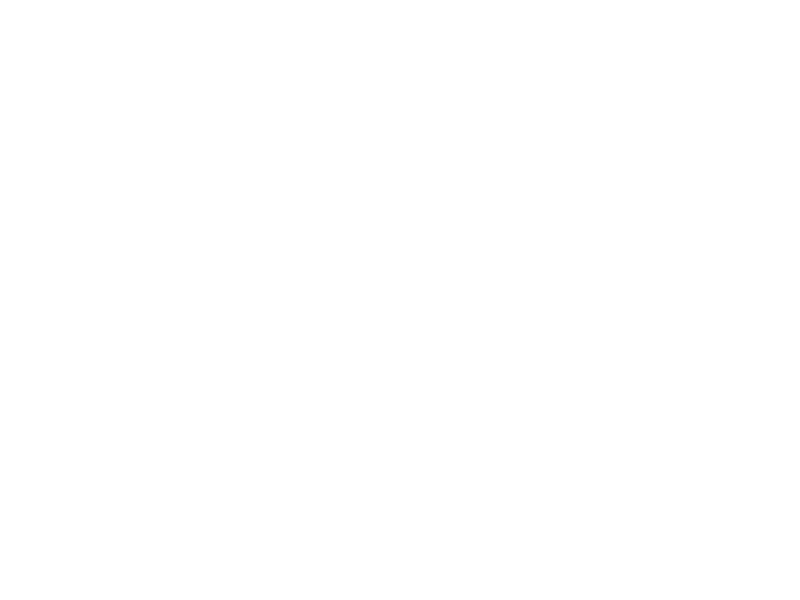

In [20]:
scenes=[]
hull=Chan(data1,scenes)
print(len(hull))
plot5=Plot(scenes = scenes)
plot5.draw()

## Dziel i rządź 

In [21]:
def mergeWithScenes(data1,data2,d):
    lines1=[]
    lines2=[]
    for i in range(0,len(data1)):
        lines1.append([data1[i],data1[(i+1)%len(data1)]])
    
    
    for i in range(0,len(data2)):
        lines2.append([data2[i],data2[(i+1)%len(data2)]])
        
    
    scenes.append(Scene([PointsCollection(d[:])],
                       [LinesCollection(lines1[:],color='green'),
                       LinesCollection(lines2[:],color='grey')]))  
    a=data1[0]
    idxa=0
    b=data2[0]
    idxb=0
    for i in range(1,len(data1)):
        if data1[i][0] > a[0]:
            a=data1[i]
            idxa=i
    for i in range(1,len(data2)):
        if data2[i][0] < b[0]:
            b=data2[i]
            idxb=i
            
            
            
    AUpper,ALower=a,a
    BUpper,BLower=b,b
    AUpperIdx,ALowerIdx=idxa,idxa
    BUpperIdx,BLowerIdx=idxb,idxb
    
    
   
    
    
    sizeA=len(data1)
    sizeB=len(data2)
    
    #lower
    
    while orient(data1[(ALowerIdx +sizeA -1)%sizeA],ALower,BLower)!=-1 or  orient(data2[(BLowerIdx+1)%sizeB],BLower,ALower)!=1:
        
        
        while orient(data1[(ALowerIdx -1+sizeA)%sizeA],ALower,BLower)!=-1:
            
            ALower=data1[(ALowerIdx -1+sizeA)%sizeA]
            ALowerIdx=(ALowerIdx -1+sizeA)%sizeA
        
       
        while orient(data2[(BLowerIdx+1)%sizeB],BLower,ALower)!=1:
           
            BLower=data2[(BLowerIdx+1)%sizeB]
            BLowerIdx=(BLowerIdx+1)%sizeB
            
        
    #upper 
    while orient(data2[(BUpperIdx -1 + sizeB)%sizeB],BUpper,AUpper)!=-1 or  orient(data1[(AUpperIdx+1)%sizeA],AUpper,BUpper)!=1:
        
       
        
        while orient(data1[(AUpperIdx+1)%sizeA],AUpper,BUpper)!=1:
            
            AUpper=data1[(AUpperIdx+1)%sizeA]
            AUpperIdx=(AUpperIdx+1)%sizeA
            
        
        
        while orient(data2[(BUpperIdx +sizeB-1)%sizeB],BUpper,AUpper)!=-1:
            BUpper=data2[(BUpperIdx -1 + sizeB)%sizeB]
            BUpperIdx=(BUpperIdx -1 + sizeB)%sizeB
            
        
    
    scenes.append(Scene([PointsCollection(d),
                        PointsCollection([ALower,BLower,AUpper,BUpper],color='red')],
                       [LinesCollection(lines1[:],color='green'),
                       LinesCollection(lines2[:],color='grey')]))
                       
    
    
    result=[]
    tmpidx=AUpperIdx
    tmp=AUpper
    #print(ALowerIdx)
    result.append(tmp)
    while(tmp!=ALower):
        tmpidx=(tmpidx+1)%len(data1)
        tmp=data1[tmpidx]
        result.append(tmp)
        
    tmp=BLower
    tmpidx=BLowerIdx
    result.append(tmp)
    while(tmp!=BUpper):
        #print(tmpidx)
        tmpidx=(tmpidx+1)%len(data2)
        tmp=data2[tmpidx]
        result.append(tmp)
    
    lines=[]
    for i in range(0,len(result)):
        lines.append([result[i],result[(i+1)%len(result)]])
        
    scenes.append(Scene([PointsCollection(d),
                        PointsCollection([ALower,BLower,AUpper,BUpper],color='red')],
                       [LinesCollection(lines1[:],color='green'),
                       LinesCollection(lines2[:],color='grey'),
                       LinesCollection(lines[:],color='red')]))
    return result
    

In [22]:
def divideAndConquer(data):
    n=len(data)
    k=5
    if n <=k: return grahamChan(data)
    data.sort(key=lambda x: x[0])
    data1=data[:n//2]
    data2=data[n//2:]
    
    data1=divideAndConquer(data1)
    data2=divideAndConquer(data2)
  
    return merge(data1,data2)
    
    

In [23]:
def divideAndConquerWithScenes(data,scenes,d):
    
    n=len(data)
    k=10
    if n <=k: return grahamChan(data)
    data.sort(key=lambda x: x[0])
    data1=data[:n//2]
    data2=data[n//2:]
    
    data1=divideAndConquerWithScenes(data1,scenes,d)
    data2=divideAndConquerWithScenes(data2,scenes,d)
  
    return mergeWithScenes(data1,data2,d)
    

<IPython.core.display.Javascript object>


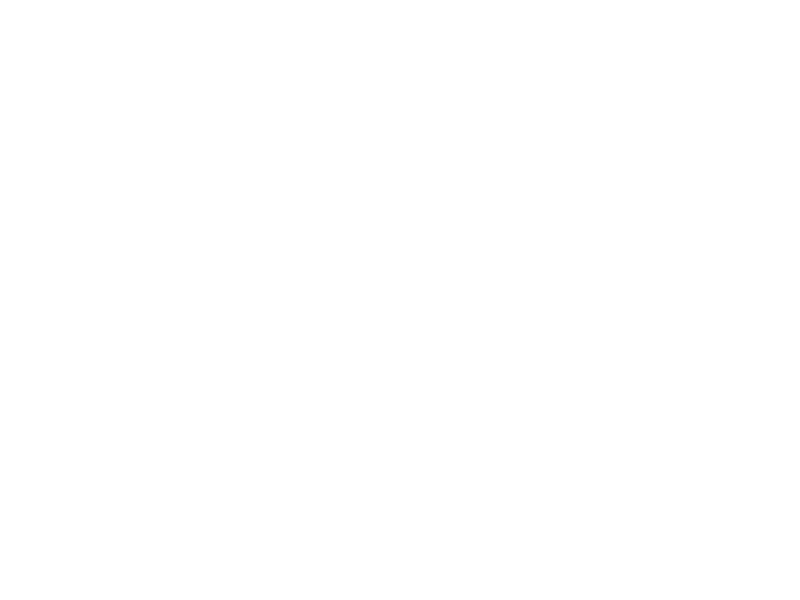

In [24]:
scenes=[]
res=divideAndConquerWithScenes(data1,scenes,data1)
lines=[]
for i in range(0,len(res)):
        lines.append([res[i],res[(i+1)%len(res)]])
        
scenes.append(Scene([PointsCollection(data1)],
                   [LinesCollection(lines,color='red')]))

plot6=Plot(scenes = scenes)
plot6.draw()

## Przyrostowy

In [25]:
def incrementalScenes(data):
    
    scenes=[]
    scenes.append(Scene([PointsCollection(data)]))
    
    sortedData=sorted(data,key = lambda p: (p[0],p[1]))
    
    d=[]
    d.append(sortedData[0])
    i=1
    last=sortedData[0][0]
    while i < len(sortedData):
        if sortedData[i][0] != last:
            d.append(sortedData[i])
            last=sortedData[i][0]
        else:
            while i <len(sortedData) and last==sortedData[i][0] :
                i+=1
            i-=1
            if i<len(sortedData):
                d.append(sortedData[i])
                last=sortedData[i][0]
            
        i+=1
                
        
                
   
    CH=[]
    CH=d[:3]
    lines=[]
    for i in range(len(CH)):
        lines.append([CH[i],CH[(i+1)%len(CH)]])
    scenes.append(Scene([PointsCollection(data)],
                        [LinesCollection(lines[:],color='red')]))
    
    for i in range(3,len(d)):
        upper,lower=CH[-1],CH[-1]
        point=d[i]
        for j in range(0,len(CH)-1):
            if orient(point,upper,CH[j])==1:
                upper= CH[j]
            if orient(point,lower,CH[j])==-1:
                lower=CH[j]
                
        scenes.append(Scene([PointsCollection(data)],
                           [LinesCollection(lines[:],color='red'),
                           LinesCollection([[point,lower],[point,upper]],color='green')]))
        tmpCH=[]
        for p in CH:
            if p!=lower and p!=upper:
                if orient(lower,upper,p) !=1:
                    tmpCH.append(p)
                    
            
        tmpCH.append(lower)
        tmpCH.append(upper)
        tmpCH.append(point)
        
        CH=grahamChan(tmpCH)
        lines=[]
        for i in range(len(CH)):
            lines.append([CH[i],CH[(i+1)%len(CH)]])
        scenes.append(Scene([PointsCollection(data)],
                           [LinesCollection(lines[:],color='red')]))
        
        
    return CH,scenes
        
            
    
   
        
    

100


<IPython.core.display.Javascript object>


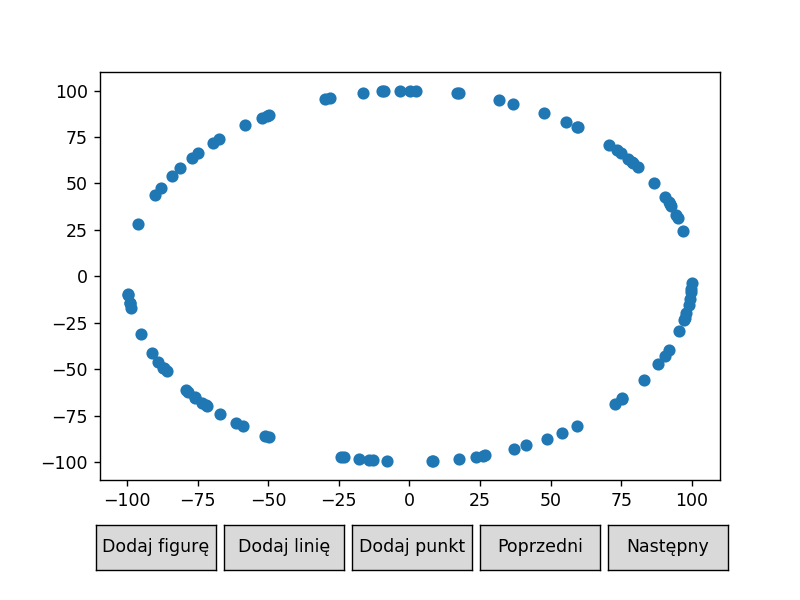

In [26]:
result, s=incrementalScenes(data2)
plot7=Plot(scenes = s)
print(len(result))
plot7.draw()

## Czasy


In [27]:
def grahamTime(data):
    data.sort(key =lambda item: (item[1],item[0]))
    p0 =data[0]
    data= data[1:]
    data = sorted(data, key=functools.cmp_to_key(lambda x,y: orient(p0,x,y)))
    m = len(data)
    data_d=[]
    data_d.append(p0)
    data_d.append(data[0])
    
    for i in range (1,m):
        p=data_d.pop()
        d=det3x3(p0,p,data[i])
        if d ==0:
            if distance(p0,p) > distance(p0,data[i]):
                data_d.append(p)
            else: data_d.append(data[i])
        else: 
            data_d.append(p)
            data_d.append(data[i])


    s=[]
    s.append(p0)
    s.append(data_d[1])
    i=2

    while i < len(data_d): 
        pt=s.pop()
        pp=s.pop()
        pi=data_d[i]
        if orient(pp,pt,pi) < 0:
            s.append(pp)
            s.append(pt)
            s.append(pi)
            i+=1
        elif orient(pp,pt,pi) ==0:
            s.append(pp)
            s.append(pi)
            i+=1
        else: s.append(pp)
    
    

In [28]:
def jarvisTime(data):
    d=set(data)
    p0=min(data,key=lambda x: (x[1],x[0]))
    s=[p0]
    p=p0
    while True:
        pi=p
        tmp=[]
        for pkt in d:
            if pkt!=p:
                pi,x=min_angleJarvis(p,pi,pkt)
                if x!=None:
                    tmp.append(x)
        for pkt in tmp:
            d.remove(pkt)
        d.remove(pi)
        p=pi
        if p==p0: break

In [29]:
def lowerAndUpperTime(data):
    d=data[:]
    d = sorted(d, key=lambda x: x[1])
    d = sorted(d, key=lambda x: x[0])
    
    stackL=[]
    stackL.append(d[0])
    stackL.append(d[1])
   
    stackU=[]
    
    stackU.append(d[0])
    stackU.append(d[1])
    for i in range(2,len(d)):
        p=d[i]
        
        
        if orient(stackL[-2],stackL[-1],p)!=-1: 
            stackL.pop()
            
            while len(stackL)>1 and orient(stackL[-2],stackL[-1],p)!=-1:
                stackL.pop()
                
        stackL.append(p)
        
        p=d[i]
        
        if orient(stackU[-2],stackU[-1],p)!=1: 
            stackU.pop()
          
            while len(stackU)>1 and orient(stackU[-2],stackU[-1],p)!=1:
                stackU.pop()
 
        stackU.append(p)
        
        
    
    
    
        

    result=[]
    result=stackL[:]
    for i in range (1,len(stackU)-1):
        result.append(stackU[i])

    return result
        

    
    

In [30]:
def incrementalTime(data):
    
   
    
    sortedData=sorted(data,key = lambda p: (p[0],p[1]))
    
    d=[]
    d.append(sortedData[0])
    i=1
    last=sortedData[0][0]
    while i < len(sortedData):
        if sortedData[i][0] != last:
            d.append(sortedData[i])
            last=sortedData[i][0]
        else:
            while i <len(sortedData) and last==sortedData[i][0] :
                i+=1
            i-=1
            if i<len(sortedData):
                d.append(sortedData[i])
                last=sortedData[i][0]
            
        i+=1
                
        
                
   
    CH=[]
    
    CH=d[:3]
    CH.sort(key = lambda p: p[0])
    CH.sort(key = lambda p: p[1],reverse=True)
    
    
    for i in range(3,len(d)):
        upper,lower=CH[-1],CH[-1]
        upperIdx,lowerIdx = len(CH)-1,len(CH)-1
        point=d[i]
        while orient(point,upper,CH[(upperIdx+1)%len(CH)])!=-1:
            upper=CH[(upperIdx+1)%len(CH)]
            upperIdx=(upperIdx+1)%len(CH)
        while orient(point,lower,CH[(lowerIdx+len(CH)-1)%len(CH)])!=1:
            lower=CH[(lowerIdx+len(CH)-1)%len(CH)]
            lowerIdx=(lowerIdx+len(CH)-1)%len(CH)
           
                
        
        tmpCH=[]
        tmpidx=upperIdx
        tmp=upper
        #print(ALowerIdx)
        tmpCH.append(tmp)
        while(tmp!=lower):
            tmpidx=(tmpidx+1)%len(CH)
            tmp=CH[tmpidx]
            tmpCH.append(tmp)
            
        
        tmpCH.append(point) 
        CH=tmpCH[:]
            
    
        
        
    return CH

In [31]:
def PartialHullTime(data,m):
    n=len(data)
    convexHull=[]
    r=math.ceil(len(data)/m)
    p1=data[0]
    S=[[] for i in range (r)]
    for i in range (n):
        S[i%r].append(data[i])
        if p1[1]> data[i][1]:
            p1=data[i]
        elif p1[1]== data[i][1]:
            if p1[0]> data[i][0]:
                p1=data[i]
        
    convexHull.append(p1)
    
    result=[[] for i in range(r)]
    for i in range (len(S)):
        result[i]=set(grahamChan(S[i]))
    
    p0=p1
    
    for i in range (m):
        q=[]
        for s in result: 
            pi=p1
            tmp=[]
            for pkt in s:
                if pkt!=p1:
                    pi,x=min_angleJarvis(p1,pi,pkt) 
                    if x!= None:
                        tmp.append(x)
                        
            for pkt in tmp:
                s.remove(pkt)
            if pi in s: 
                s.remove(pi)
            q.append(pi)
        
        p=p1
        for pkt in q:
            if pkt!=p1:
                p=min_angle(p1,p,pkt) 
        
        if p==p0:
            return convexHull
            
        else:
            convexHull.append(p)
            p1=p
            
            
        
    return None

In [32]:
def chanTime(data):
    n=len(data)
    t=1
    L=None
    while(True):
        m=min(2**(2**t),n)
        scenes.clear()
        L=PartialHullTime(data,m)
        if L!=None:
            break
        t+=1
        
    return L
        

In [33]:
def mergeTime(data1,data2):
    
    a=data1[0]
    idxa=0
    b=data2[0]
    idxb=0
    for i in range(1,len(data1)):
        if data1[i][0] > a[0]:
            a=data1[i]
            idxa=i
    for i in range(1,len(data2)):
        if data2[i][0] < b[0]:
            b=data2[i]
            idxb=i
            
            
            
    AUpper,ALower=a,a
    BUpper,BLower=b,b
    AUpperIdx,ALowerIdx=idxa,idxa
    BUpperIdx,BLowerIdx=idxb,idxb
    
    
   
    
    
    sizeA=len(data1)
    sizeB=len(data2)
    
    #lower
    
    while orient(data1[(ALowerIdx +sizeA -1)%sizeA],ALower,BLower)!=-1 or  orient(data2[(BLowerIdx+1)%sizeB],BLower,ALower)!=1:
        
        
        while orient(data1[(ALowerIdx -1+sizeA)%sizeA],ALower,BLower)!=-1:
            
            ALower=data1[(ALowerIdx -1+sizeA)%sizeA]
            ALowerIdx=(ALowerIdx -1+sizeA)%sizeA
        
       
        while orient(data2[(BLowerIdx+1)%sizeB],BLower,ALower)!=1:
           
            BLower=data2[(BLowerIdx+1)%sizeB]
            BLowerIdx=(BLowerIdx+1)%sizeB
            
        
    #upper 
    while orient(data2[(BUpperIdx -1 + sizeB)%sizeB],BUpper,AUpper)!=-1 or  orient(data1[(AUpperIdx+1)%sizeA],AUpper,BUpper)!=1:
        
       
        
        while orient(data1[(AUpperIdx+1)%sizeA],AUpper,BUpper)!=1:
            
            AUpper=data1[(AUpperIdx+1)%sizeA]
            AUpperIdx=(AUpperIdx+1)%sizeA
            
        
        
        while orient(data2[(BUpperIdx +sizeB-1)%sizeB],BUpper,AUpper)!=-1:
            BUpper=data2[(BUpperIdx -1 + sizeB)%sizeB]
            BUpperIdx=(BUpperIdx -1 + sizeB)%sizeB
            
        
    
        
    result=[]
    tmpidx=AUpperIdx
    tmp=AUpper
    #print(ALowerIdx)
    result.append(tmp)
    while(tmp!=ALower):
        tmpidx=(tmpidx+1)%len(data1)
        tmp=data1[tmpidx]
        result.append(tmp)
        
    tmp=BLower
    tmpidx=BLowerIdx
    result.append(tmp)
    while(tmp!=BUpper):
        #print(tmpidx)
        tmpidx=(tmpidx+1)%len(data2)
        tmp=data2[tmpidx]
        result.append(tmp)
        
    return result

In [34]:
def divideAndConquerTime(data):
    n=len(data)
    k=10
    if n <=k: return grahamChan(data)
    data.sort(key=lambda x: x[0])
    data1=data[:n//2]
    data2=data[n//2:]
    
    data1=divideAndConquerTime(data1)
    data2=divideAndConquerTime(data2)
  
    return mergeTime(data1,data2)
    

In [35]:
result=[]
def startQuickHullTime(data):
    data.sort(key=lambda x: x[1])
    data.sort(key=lambda x: x[0])
    Left=data[0]
    Right=data[-1]
    upper=[]
    lower=[]
    for p in data:
        if orient(Left,Right,p)==1:
            lower.append(p)
        elif orient(Left,Right,p)==-1:
            upper.append(p)
    
    QuickHullTime(Left,Right,upper) 
    QuickHullTime(Right,Left,lower)
    
    
def QuickHullTime(a,b,S):
    if len(S)==0:  
        result.append(a)
        result.append(b)
        return
    elif len(S)==1:
        result.append(S[0])
        result.append(a)
        result.append(b)
        return
    else:
        maxD=0
        p=S[0]
        for el in S:
            if findDistance(a,b,el) >maxD:
                p=el
                maxD=findDistance(a,b,el)
        array1=[]
        array2=[]
        for el in S:
            if orient(a,p,el)==-1:
                array1.append(el)
            elif orient(p,b,el)==-1:
                array2.append(el)
                
                
        
    
        QuickHullTime(a,p,array1)
        QuickHullTime(p,b,array2)
                

In [36]:
import time

def print_time_graham(data):
    start2=time.time()
    grahamTime(data)
    print("graham: %s ms" % ((time.time()-start2)*1000))
    
    
def print_time_jarvis(data):
    start2=time.time()
    jarvisTime(data)
    print("jarvis: %s ms" % ((time.time()-start2)*1000))
    

def print_time_incremental(data):
    start2=time.time()
    incrementalTime(data)
    print("incremental: %s ms" % ((time.time()-start2)*1000))
    

    
def print_time_chan(data):
    start2=time.time()
    chanTime(data)
    print("chan: %s ms" % ((time.time()-start2)*1000))
    
def print_time_lowerAndUpper(data):
    start2=time.time()
    lowerAndUpperTime(data)
    print("lowerAndUpper: %s ms" % ((time.time()-start2)*1000))
    
def print_time_divideAndCounquer(data):
    start2=time.time()
    divideAndConquerTime(data)
    print("divideAndConquer: %s ms" % ((time.time()-start2)*1000))
    

def print_time_quickHull(data):
    result=[]
    start2=time.time()
    startQuickHullTime(data)
    print("quickHull: %s ms" % ((time.time()-start2)*1000))

    


In [37]:
def printTimes(data):
    print_time_graham(data)
    print_time_jarvis(data)
    print_time_incremental(data)
    print_time_chan(data)
    print_time_lowerAndUpper(data)
    print_time_quickHull(data)
    print_time_divideAndCounquer(data)
    
    

## Mierzenie czasów

In [38]:
printTimes(data1)

graham: 0.9973049163818359 ms
jarvis: 1.9943714141845703 ms
incremental: 0.0 ms
chan: 2.991914749145508 ms
lowerAndUpper: 0.9970664978027344 ms
quickHull: 0.0 ms
divideAndConquer: 0.9975433349609375 ms
